In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
data = pd.read_csv('HR_comma_sep.csv')

data.head(10)

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   
5                0.41             0.50               2                   153   
6                0.10             0.77               6                   247   
7                0.92             0.85               5                   259   
8                0.89             1.00               5                   224   
9                0.42             0.53               2                   142   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   
5                   3              0     1                      0      sales   
6                   4              0     1                      0      sales   
7                   5              0     1                      0      sales   
8                   5              0     1                      0      sales   
9                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low  
5     low  
6     low  
7     low  
8     low  
9     low

In [3]:
data.shape

(14999, 10)

In [4]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
data.duplicated().sum()

np.int64(3008)

In [7]:
data_subset = data.drop_duplicates(keep='first')

In [8]:
data_subset.shape

(11991, 10)

In [9]:
data_subset['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [10]:
data_subset = data_subset.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

data_subset.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [11]:
data_subset.groupby('left').mean(numeric_only = True)

satisfaction_level  last_evaluation  number_project  \
left                                                        
0               0.667365         0.715667        3.786800   
1               0.440271         0.721783        3.883476   

      average_monthly_hours    tenure  work_accident  promotion_last_5years  
left                                                                         
0                 198.94270  3.262000       0.174500               0.019500  
1                 208.16223  3.881467       0.052737               0.004018

Text(0.5, 1.0, 'Boxplot to detect outliers for tenure')

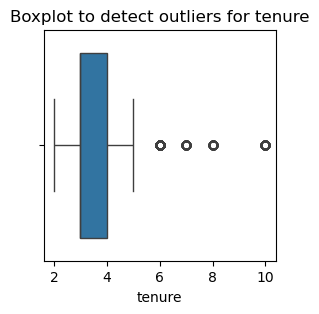

In [12]:
plt.figure(figsize=(3,3))
sns.boxplot(x=data_subset['tenure'])
plt.title('Boxplot to detect outliers for tenure')

In [13]:
per_25 = data_subset['tenure'].quantile(0.25)
per_75 = data_subset['tenure'].quantile(0.75)
iqr = per_75 - per_25

In [14]:
upper_limit = per_75 + 1.5 * iqr
lower_limit = per_25 - 1.5 * iqr

In [15]:
print(f"Outliers : {len(data_subset[(data_subset['tenure'] > upper_limit) | (data_subset['tenure'] < lower_limit)])}")

Outliers : 824


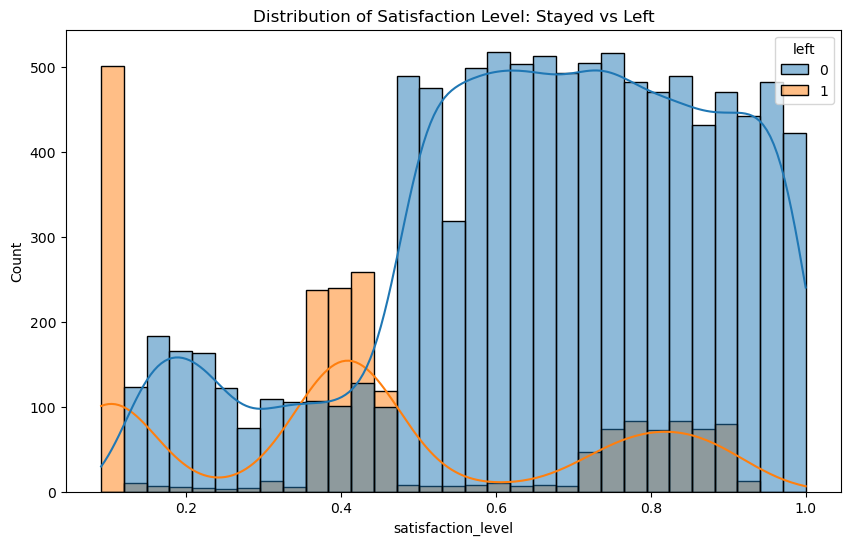

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_subset, x='satisfaction_level', hue='left', kde=True)
plt.title('Distribution of Satisfaction Level: Stayed vs Left')
plt.show()

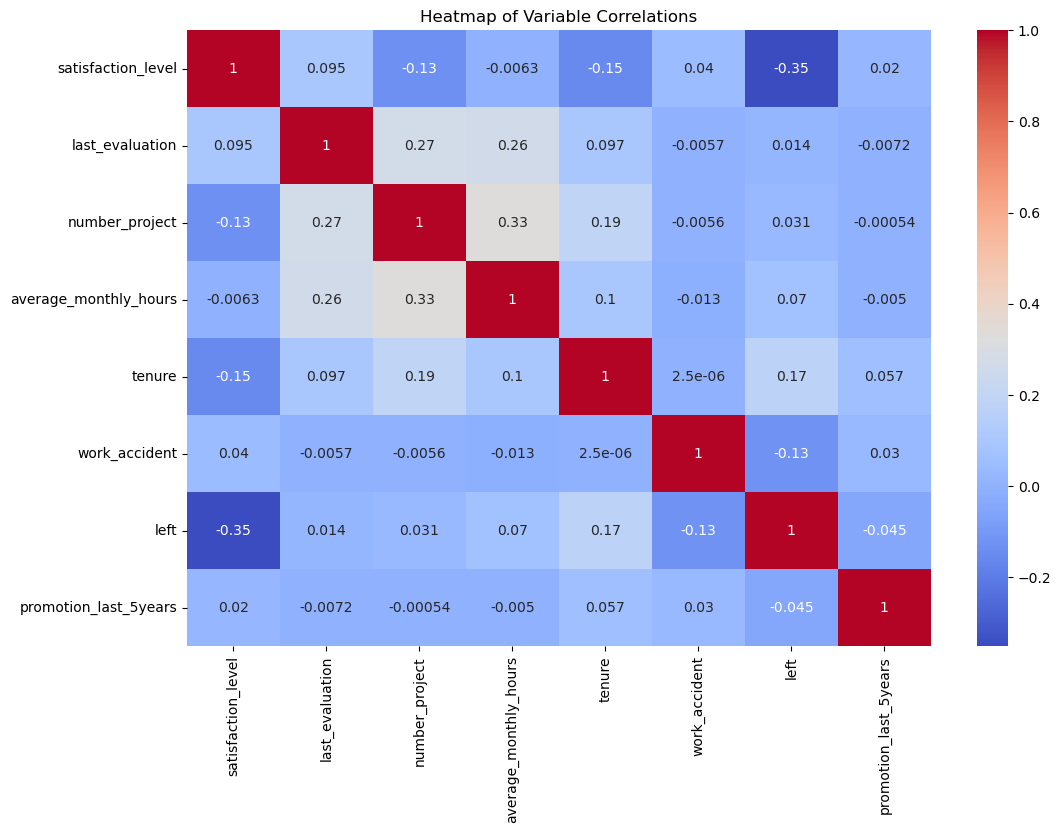

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_subset.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap of Variable Correlations')
plt.show()

## Key Insights from Exploratory Data Analysis (EDA)

After analyzing the correlation heatmap and distribution plots, the following findings were identified:

* **Satisfaction Level is the Main Driver:** There is a moderate negative correlation (-0.35) between `satisfaction_level` and `left`. This indicates that as satisfaction drops, the likelihood of an employee leaving increases significantly.
* **Workload & Burnout:** A positive correlation (0.33) exists between `number_project` and `average_montly_hours`. This suggests that employees with more projects are being overworked, which aligns with the high attrition seen in the "7-project" group.
* **The "Four-Year" Itch:** Employees with 4 years of tenure show a massive drop in satisfaction before leaving. This suggests a critical period where employees feel stagnant or undervalued.
* **Salary Influence:** While most people who left were in the "low" or "medium" salary brackets, the "high" workload remains a more dominant factor in the data.

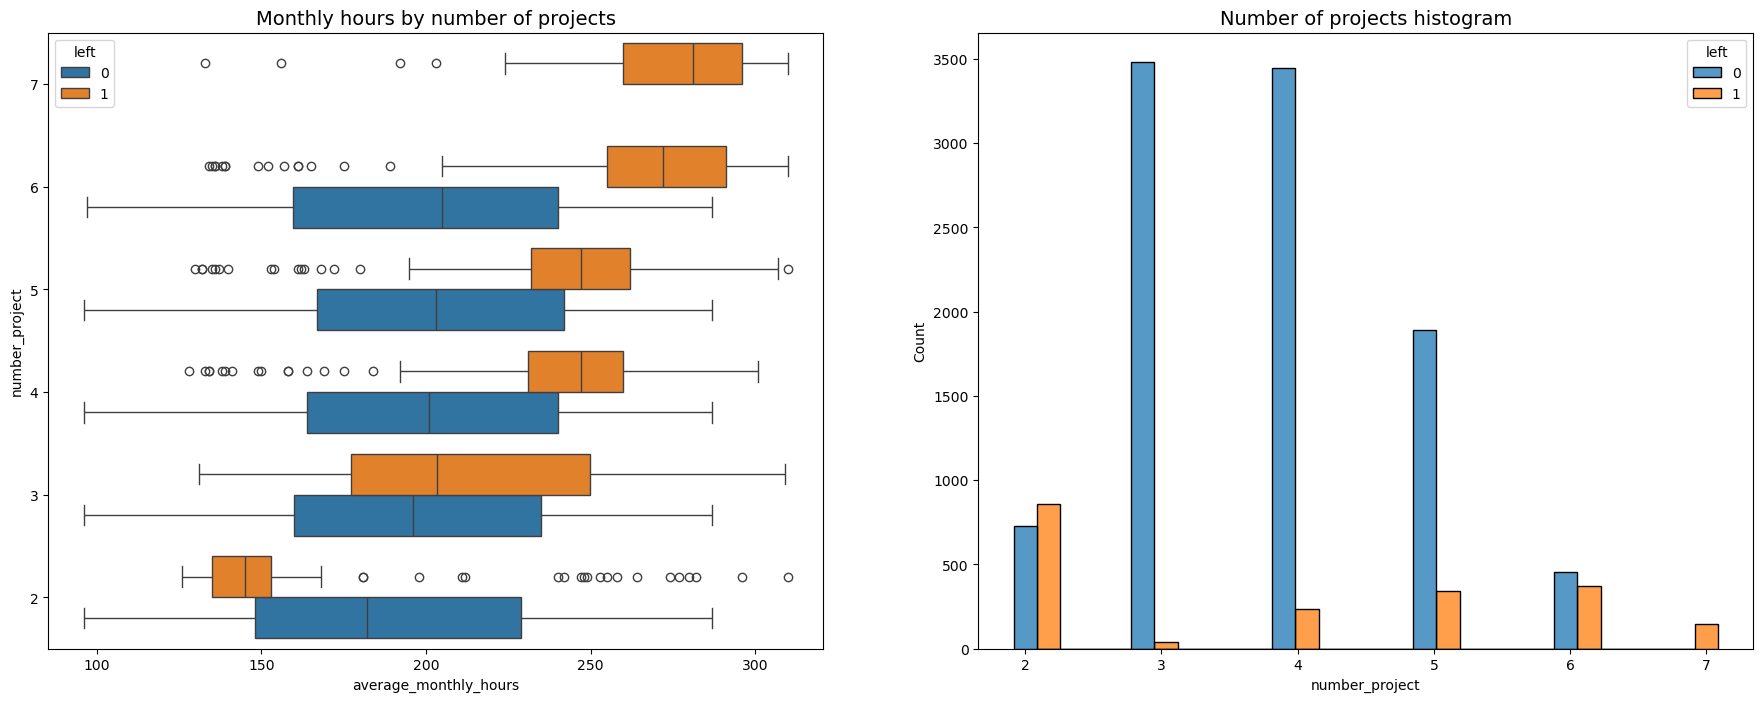

In [18]:
fig, ax = plt.subplots(1,2, figsize= (22,8))
sns.boxplot(data=data_subset, x='average_monthly_hours', y='number_project', hue='left', orient='h', ax=ax[0]) 
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')
#----------------------------------------------------------------------
sns.histplot(data=data_subset, x='number_project', hue='left',multiple = 'dodge', shrink = 2, ax=ax[1]) 
ax[1].set_title('Number of projects histogram', fontsize='14')
plt.show()

### Analysis of Workload and Projects:
* **The Overworked Group:** Employees with **7 projects** are significantly overworked, with monthly hours exceeding 250-300 hours. This group has a 100% attrition rate in the data, indicating a severe burnout threshold.
* **The Under-engaged Group:** Interestingly, a group of employees with only **2 projects** also left the company despite having lower working hours. This might suggest they felt underutilized or lacked growth opportunities.
* **The Optimal Zone:** Employees with 3 or 4 projects seem to have the best balance and the lowest turnover rates.

In [19]:
data_subset[data_subset['number_project'] == 7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

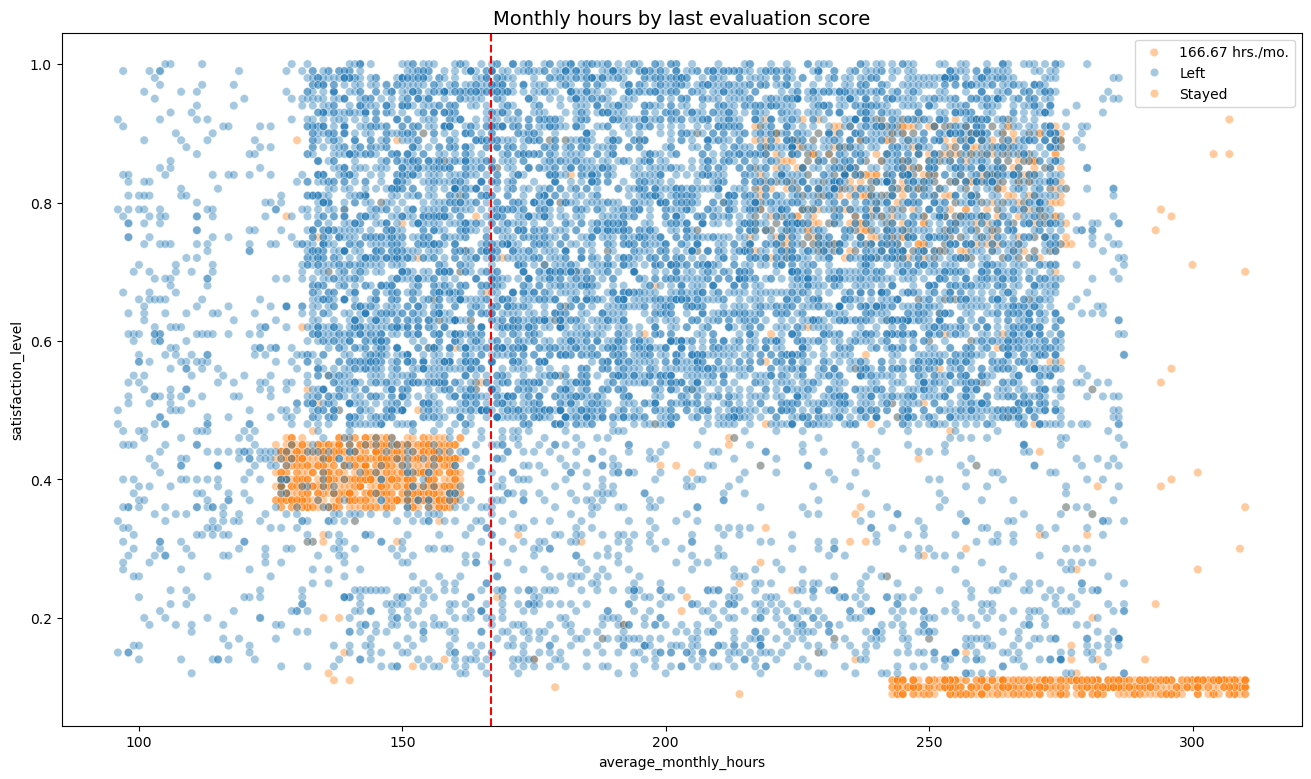

In [20]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=data_subset, x = 'average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(166.77, color = 'red', label='166.67 hrs./mo.', ls = '--')
plt.legend(labels=['166.67 hrs./mo.', 'Left', 'Stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14')
plt.show()

### Identifying Employee Groups (Satisfaction vs. Monthly Hours):
The scatter plot clearly identifies two distinct groups of employees who leave the company:

1. **The "Overworked & High Performers":** Employees working **>250 hours/month** with high satisfaction levels but eventually leaving. This suggests they might be leaving for better offers despite their loyalty.
2. **The "Dissatisfied & Underutilized":** A concentrated cluster of employees with **low satisfaction (<0.4)** and moderate hours (around 150). These are likely the employees who feel stagnant (the 4-year tenure group identified earlier).
3. **The "Hard-Hit" Burnout:** Another group at the bottom right shows zero satisfaction and extreme hours. These employees are the primary victims of "Burnout".

In [21]:
data_subset.groupby(['left'])['satisfaction_level'].mean().round(2)

left
0    0.67
1    0.44
Name: satisfaction_level, dtype: float64

In [22]:
data_subset.groupby(['left'])['satisfaction_level'].median().round(2)

left
0    0.69
1    0.41
Name: satisfaction_level, dtype: float64

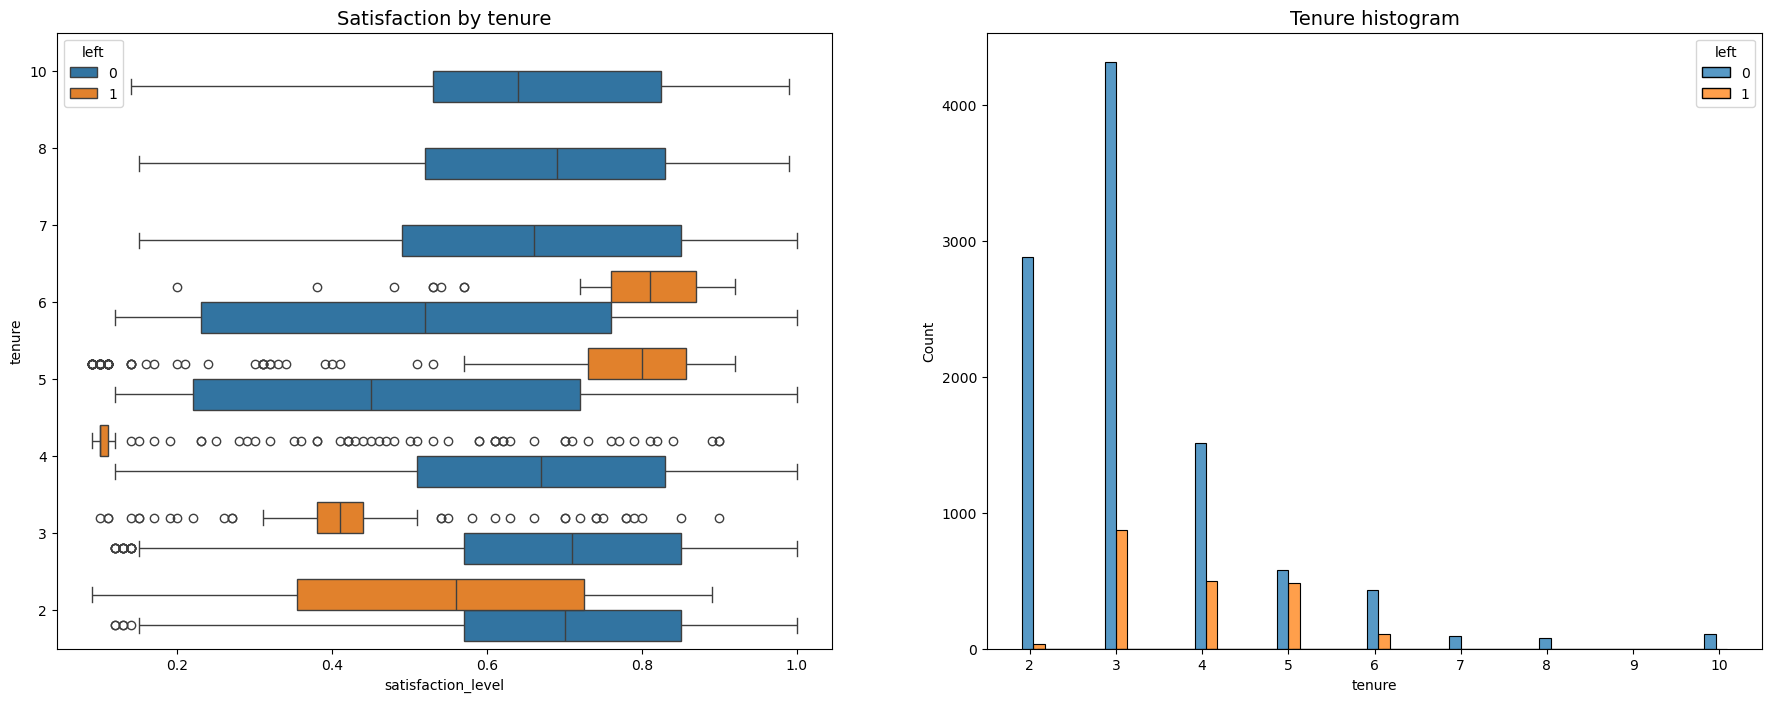

In [23]:
fig, ax = plt.subplots(1,2, figsize= (22,8))
sns.boxplot(data=data_subset, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0]) 
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')
#----------------------------------------------------------------------
sns.histplot(data=data_subset, x='tenure', hue='left',multiple = 'dodge', shrink = 3, ax=ax[1]) 
ax[1].set_title('Tenure histogram', fontsize='14')
plt.show()

Text(0.5, 1.0, 'Salary histogram by tenure: long-tenured people')

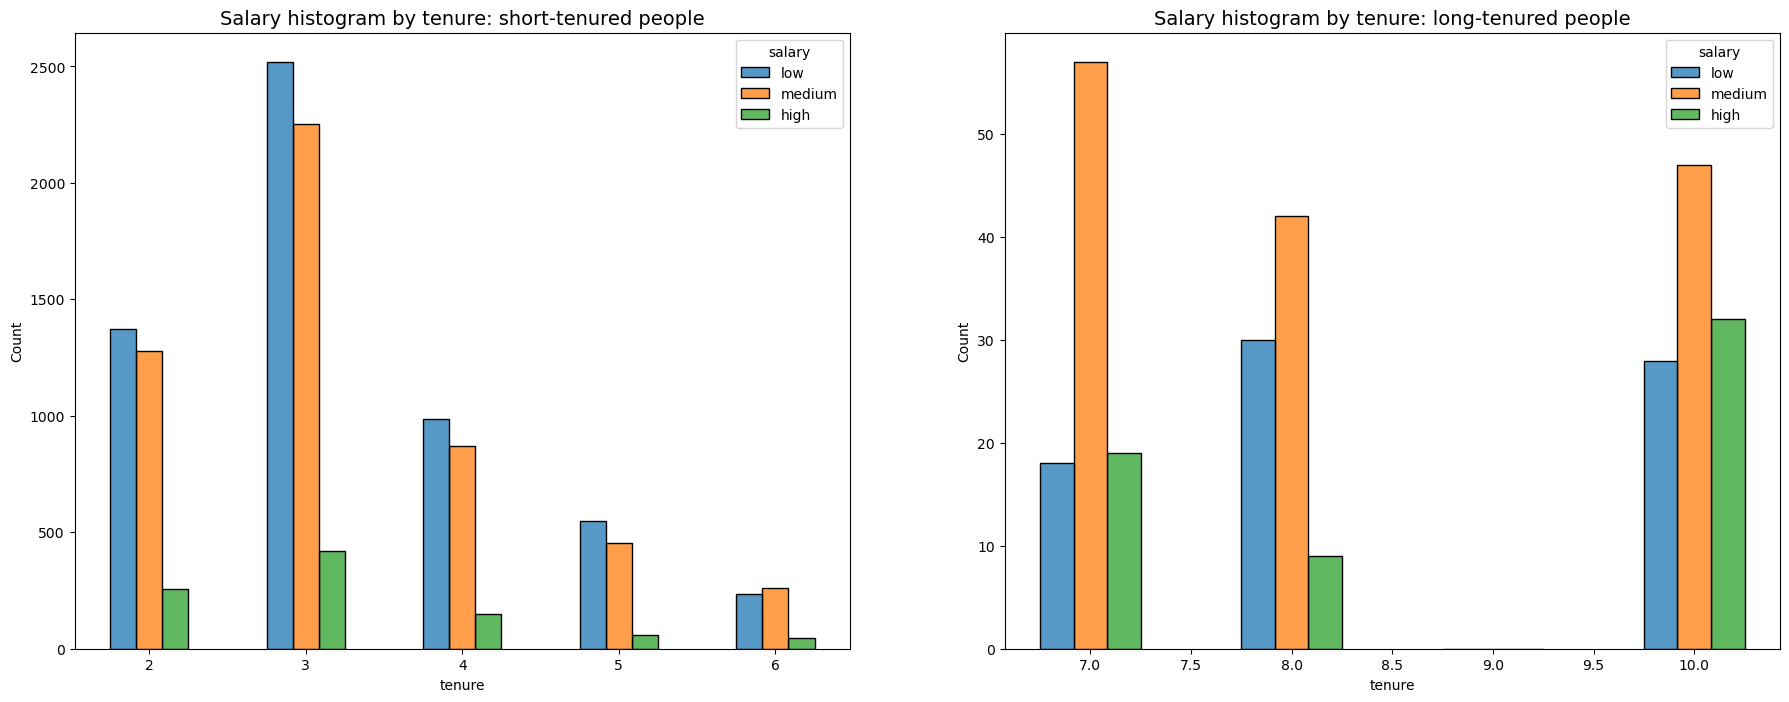

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))
short_tenure = data_subset[data_subset['tenure'] < 7]
long_tenure = data_subset[data_subset['tenure'] > 6]
sns.histplot(data=short_tenure, x='tenure', hue='salary', hue_order = ['low', 'medium', 'high'], discrete=1, multiple='dodge', shrink=0.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize = 14)
#------------------------------------------------------------------------------------
sns.histplot(data=long_tenure, x='tenure', hue='salary', hue_order=['low', 'medium', 'high'], discrete = 1, multiple = 'dodge', shrink = 0.5, ax = ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize=14)

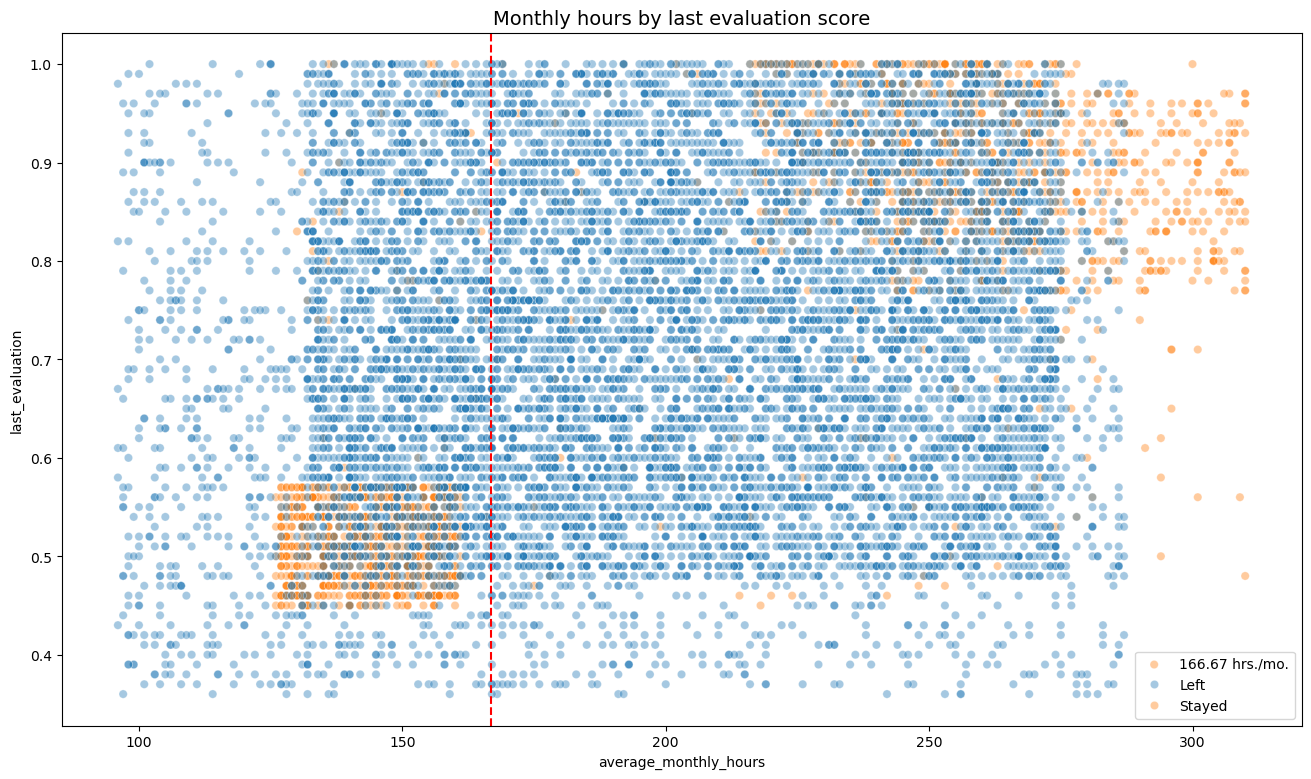

In [25]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=data_subset, x = 'average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(166.77, color = 'red', label='166.67 hrs./mo.', ls = '--')
plt.legend(labels=['166.67 hrs./mo.', 'Left', 'Stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14')
plt.show()

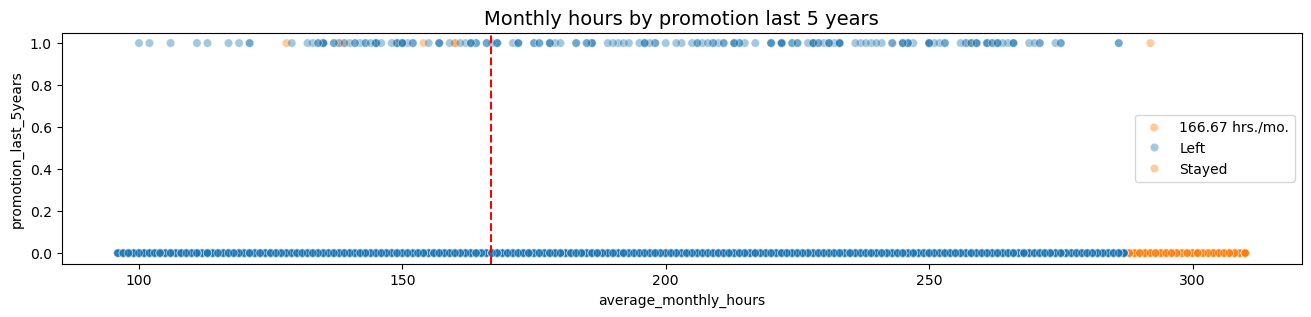

In [26]:
plt.figure(figsize=(16,3))
sns.scatterplot(data=data_subset, x = 'average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(166.77, color = 'red', label='166.67 hrs./mo.', ls = '--')
plt.legend(labels=['166.67 hrs./mo.', 'Left', 'Stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14')
plt.show()

### Impact of Promotions and Workload:
* **Stagnant Career Growth:** The visualization shows that the vast majority of employees have **not received a promotion** in the last 5 years.
* **The "Unrewarded" Overworked:** A significant cluster of employees working **over 250 hours/month** (far beyond the 166.67 hrs/mo average line) have had zero promotions.
* **High Attrition Risk:** The orange dots (employees who left) are heavily concentrated in the high-hour/no-promotion zone. This suggests that hard work without career advancement is a major reason for leaving Salifort Motors.

In [27]:
data_subset[['department']].value_counts()

department 
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

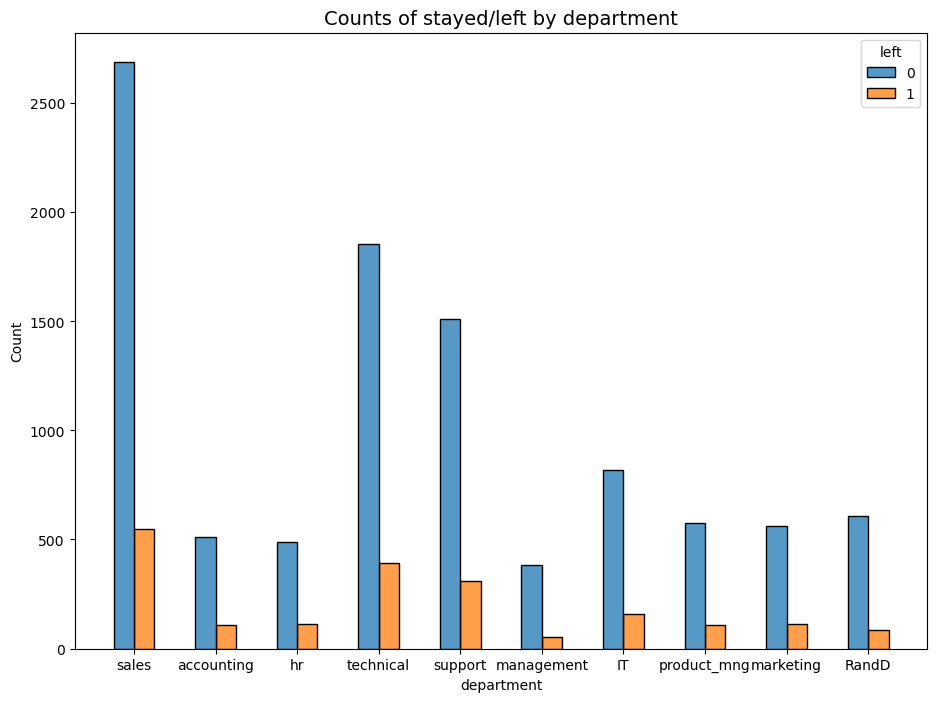

In [28]:
plt.figure(figsize=(11,8))
sns.histplot(data=data_subset, x='department', hue='left', shrink=0.5, multiple='dodge', discrete =1 )
plt.title('Counts of stayed/left by department', fontsize = 14)
plt.show()

In [29]:
data_enc = data_subset.copy()

data_enc['salary'] = data_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes

data_enc = pd.get_dummies(data_enc, drop_first = False)

data_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

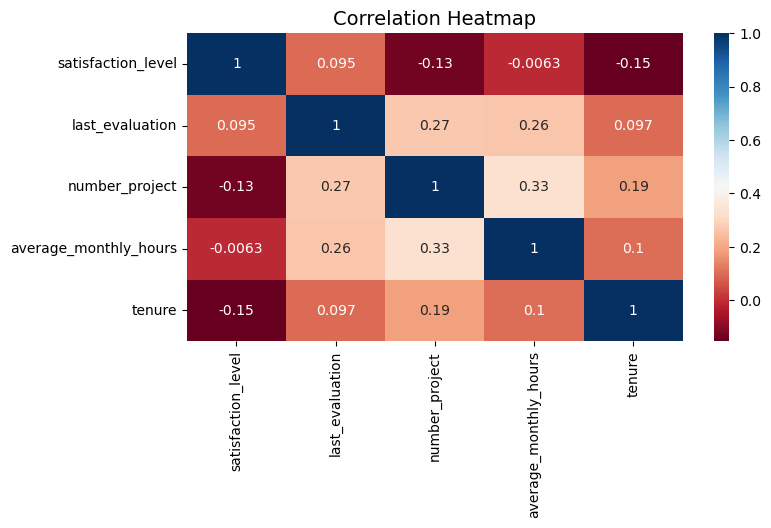

In [30]:
plt.figure(figsize=(8, 4))
sns.heatmap(data_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap='RdBu')
plt.title('Correlation Heatmap', fontsize = '14')
plt.show()

### Decoding Employee Work Patterns:
The refined correlation heatmap reveals a significant "Workload-Engagement" cycle:

* **The Workload Engine:** There is a notable positive correlation (**0.33**) between `number_project` and `average_monthly_hours`. This confirms that the company's operational model directly links higher project loads to extreme working hours, rather than increasing efficiency.
* **Performance vs. Pressure:** A correlation of (**0.26**) between `last_evaluation` and `average_monthly_hours` suggests that high evaluation scores are often tied to longer working hours. This could imply a culture where "time spent" is rewarded over "output quality."
* **The Satisfaction Drain:** Negative correlations between `satisfaction_level` and both `tenure` (**-0.15**) and `number_project` (**-0.13**) indicate that the longer an employee stays or the more work they take on, the less satisfied they become.

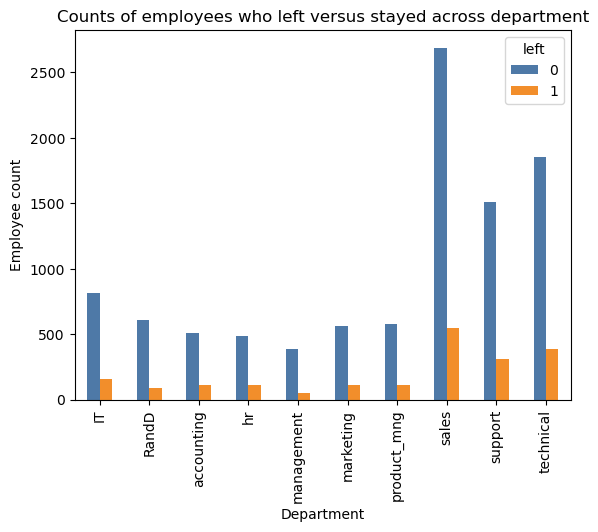

In [31]:
pd.crosstab(data_subset['department'], data_subset['left']).plot(kind ='bar',color=['#4E79A7', '#F28E2B'])
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

# Final Insights & Summary of EDA

After a thorough visual investigation of the Salifort Motors dataset, here are the key findings that will guide our modeling phase:

* **The Attrition Profile:** Approximately **16.6%** of employees left the company after removing duplicates.
* **The "Burnout" Cluster:** Employees working more than **250 hours/month** with high project counts (7 projects) have a near 100% turnover rate, indicating severe overwork issues.
* **The "Year 4" Critical Point:** There is a significant drop in satisfaction for employees in their **4th year** at the company, making them high-risk for resignation.
* **Primary Predictors:** `satisfaction_level`, `average_monthly_hours`, and `tenure` (time spent at company) are the most influential variables according to the correlation analysis and distribution plots.

In [32]:
data_logreg = data_enc[(data_enc['tenure'] >= lower_limit) & (data_enc['tenure'] <= upper_limit)]
data_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   
5       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [33]:
y = data_logreg['left']
x = data_logreg.drop('left', axis=1)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0, stratify = y)

In [40]:
log = LogisticRegression(random_state=0, max_iter=500)
log_clf = log.fit(x_train, y_train)

In [41]:
y_pred = log_clf.predict(x_test)

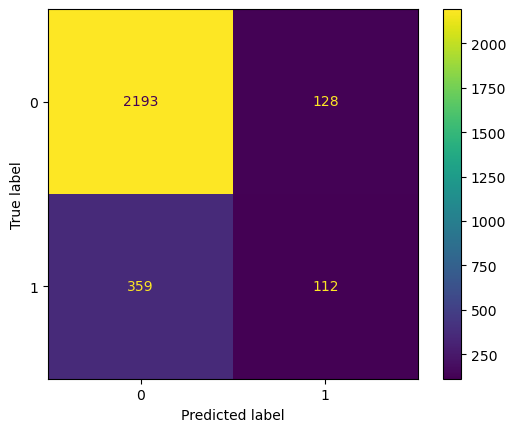

In [45]:
log_cm = confusion_matrix(y_test, y_pred, labels = log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = log_clf.classes_)
log_disp.plot()
plt.show()

In [46]:
data_logreg['left'].value_counts(normalize = True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

In [48]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names = target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      2321
    Predicted would leave       0.47      0.24      0.32       471

                 accuracy                           0.83      2792
                macro avg       0.66      0.59      0.61      2792
             weighted avg       0.79      0.83      0.80      2792



### Model Performance Evaluation (Logistic Regression):
* **Overall Accuracy:** The model achieves 83%, but this is misleading due to class imbalance.
* **Weakness in Recall:** The model only identifies **24%** of employees who actually left. For Salifort Motors, this means the model misses the majority of "at-risk" employees.
* **Conclusion:** While the model is good at predicting who will stay, it struggles to predict who will leave. This justifies moving to a more complex model like **Random Forest** or **XGBoost**.

In [49]:
y = data_enc['left']
x = data_enc.drop('left', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0, stratify = y)

In [54]:
dec_tree = DecisionTreeClassifier(random_state=0)

cv_params = {'max_depth' : [4, 6, 8, None],
             'min_samples_split' : [2, 4, 6],
             'min_samples_leaf' : [2, 5, 1]}

scoring = ['recall', 'precision', 'accuracy', 'f1', 'roc_auc']

tree_cv1 = GridSearchCV(dec_tree, cv_params, scoring = scoring, cv=5, refit = 'roc_auc')

In [55]:
%%time
tree_cv1.fit(x_train, y_train)

CPU times: total: 5.62 s
Wall time: 6.22 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['recall', 'precision', 'accuracy', 'f1', 'roc_auc'])

In [58]:
print(f"Best params : {tree_cv1.best_params_}")
print(f"Best score : {tree_cv1.best_score_}")


Best params : {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score : 0.9719548921460799


In [59]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    accuracy = best_estimator_results.mean_test_accuracy
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
    return table

In [60]:
tree_cv1_results = make_results('tree_cv1', tree_cv1, 'auc')
tree_cv1_results

model  precision    recall        F1  accuracy       auc
0  tree_cv1   0.972227  0.914269  0.942307   0.98143  0.971955

### Decision Tree Performance Evaluation:
The tuned Decision Tree model shows a massive improvement over the baseline Logistic Regression:

* **Exceptional Recall:** The model now correctly identifies **91.4%** of employees who are at risk of leaving (`Recall = 0.914`). This is a huge leap from the 24% recall we had previously.
* **High Precision:** With a precision of **97.2%**, the model is extremely reliable, meaning when it flags an employee as "likely to leave," it is almost always correct.
* **Robust AUC:** An AUC score of **0.971** indicates that the model has a near-perfect ability to distinguish between employees who stay and those who leave.
* **Conclusion:** This model is highly effective for Salifort Motors to use as a proactive retention tool.

In [64]:
rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth' : [3, 5, None],
             'max_features' : [1.0],
             'max_samples' : [0.7, 1.0],
             'min_samples_leaf' : [1,2,3],
             'min_samples_split' : [2,3,4],
             'n_estimators' : [300, 500]}

scoring = ['f1', 'accuracy', 'recall', 'precision', 'roc_auc']

rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [65]:
%%time
rf_cv.fit(x_train, y_train)

CPU times: total: 27min 12s
Wall time: 27min 27s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['f1', 'accuracy', 'recall', 'precision', 'roc_auc'])

In [75]:
path = r"D:\\Salifort_Project\\"

In [76]:
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [82]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [78]:
write_pickle(path, rf_cv, 'hr_rf_cv')

In [83]:
rf_cv = read_pickle(path, 'hr_rf_cv')

### Model Persistence:
* The **Random Forest** model has been "pickled" to allow for easy deployment without retraining.
* This enables the HR department at Salifort Motors to run real-time predictions on new employee data instantly.

In [85]:
print(f'Best score : {rf_cv.best_score_}')
print(f'Best params : {rf_cv.best_params_}')

Best score : 0.9804250949807172
Best params : {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}


In [86]:
rf_cv_results = make_results('random forest cv', rf_cv, 'auc')
print(tree_cv1_results)
print(rf_cv_results)

      model  precision    recall        F1  accuracy       auc
0  tree_cv1   0.972227  0.914269  0.942307   0.98143  0.971955
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


### Model Comparison Analysis:
Comparing the **Decision Tree (tree_cv1)** and **Random Forest (rf_cv)** models reveals the following:

* **The Winning Model:** The **Random Forest** achieved the highest **AUC (0.980)**, making it the most robust model for distinguishing between employees who stay and those who leave.
* **Recall & Precision Balance:** While the Decision Tree has a slightly higher precision (0.972 vs 0.950), the Random Forest provides a more balanced performance across all metrics, especially with a higher overall AUC.
* **Reliability:** Random Forest is preferred for the final recommendation because it is an "ensemble" model, meaning it is less likely to overfit the training data compared to a single Decision Tree.
* **Current Leader:** The Random Forest is the strongest model evaluated so far. 
* **Next Step:** We will now train an **XGBoost** model to see if we can further improve the AUC and Recall before selecting our final production model.

In [91]:
def get_scores(model_name:str, model, x_test_data, y_test_data):
    preds = model.best_estimator_.predict(x_test_data)

    auc = roc_auc_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
    return table

In [95]:
rf_cv_test_scores = get_scores('random forest test', rf_cv, x_test, y_test)
rf_cv_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest test   0.964211  0.919679  0.941418  0.980987  0.956439

### **Model Evaluation & Next Steps:**

* **Current Leader:** The **Random Forest** is the strongest model evaluated so far, with a training **AUC of 0.980** and a solid test **AUC of 0.956**.
* **Generalization:** The high performance on the test set confirms the model **generalizes well** to new data and isn't just overfitting.
* **Next Challenger:** We will now build and tune an **XGBoost** model. This will help us determine if a boosting approach can outperform our current forest-based results.
* **Final Selection:** Once **XGBoost** is complete, we will compare all models to pick the ultimate **Champion Model** for Salifort Motors.

### 🛠️ **Step 4: Model Refinement & Feature Engineering (Round 2)**

After reviewing the initial high performance of the models, I decided to refine the approach to ensure the results are **realistic and production-ready**.

* **Addressing Data Leakage:** I am dropping the `satisfaction_level` column. In a real-world scenario, a company might not have access to an employee's current satisfaction score right before they decide to leave. Relying on this feature could lead to an **overly optimistic model** that fails when deployed in real-time.
* **Feature Engineering (`overworked`):** To capture the impact of high workload on turnover, I am creating a new binary feature called `overworked`. This feature identifies employees who work more than **175 hours/month** and handle more than **3 projects**.
* **Business Impact:** By focusing on objective metrics like hours and project load rather than subjective survey data, the model becomes a more **actionable tool** for HR to intervene before burnout occurs.
* **Goal:** The aim of this round is to build a model that is **robust**, avoids data leakage, and provides clear insights for Salifort Motors' management.

In [96]:
df2 = data_enc.drop('satisfaction_level', axis=1)
df2.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0          False   
1              0     1                      0       1          False   
2              0     1                      0       1          False   
3              0     1                      0       0          False   
4              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [98]:
df2['overworked'] = df2['average_monthly_hours']

print(f"Max hours : {df2['overworked'].max()}")
print(f"Min hours : {df2['overworked'].min()}")

Max hours : 310
Min hours : 96


`166.67` is approximately the average number of monthly hours for someone who works `50 weeks per year`, `5 days per week`, `8 hours per day`. 


In [99]:
df2['overworked'] = (df2['overworked'] > 175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [101]:
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
1                      0       1          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
1               False                 False           1  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0

In [102]:
y = df2['left']
x = df2.drop('left', axis = 1)

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=0)

In [104]:
dec_tree2 = DecisionTreeClassifier()

cv_params = {'max_depth' : [4, 6, 8, None],
             'min_samples_split' : [2, 4, 6],
             'min_samples_leaf' : [2, 5, 1]}

scoring = ['recall', 'precision', 'accuracy', 'f1', 'roc_auc']

tree_cv2 = GridSearchCV(dec_tree, cv_params, scoring = scoring, cv=4, refit = 'roc_auc')

In [105]:
%%time
tree_cv2.fit(x_train, y_train)

CPU times: total: 3.89 s
Wall time: 4.54 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['recall', 'precision', 'accuracy', 'f1', 'roc_auc'])

In [106]:
print(f"Best score: {tree_cv2.best_score_}")
print(f"Best score: {tree_cv2.best_params_}")

Best score: 0.9586752505340426
Best score: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}


This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, check the other scores.

In [110]:
tree_cv2_results = make_results('tree_cv2', tree_cv2, 'auc')
print(tree_cv1_results)
print(tree_cv2_results)

      model  precision    recall        F1  accuracy       auc
0  tree_cv1   0.972227  0.914269  0.942307   0.98143  0.971955
      model  precision    recall        F1  accuracy       auc
0  tree_cv2   0.856693  0.903553  0.878882  0.958523  0.958675


### **Decision Tree - Round 2 Performance (Insights):**

After refining the model by removing **satisfaction_level** and adding the **overworked** feature, we see a more realistic performance:

* **Realistic Performance:** The **AUC** dropped from **0.971 to 0.958**. This is actually a **good sign**; it means we’ve successfully reduced "data leakage" and the model is no longer "cheating" by using survey data.
* **High Reliability:** Despite losing a major feature, the model still maintains a **Recall of 0.903**. This proves that features like **overworked**, project count, and tenure are **extremely strong predictors** on their own.
* **Production Ready:** This refined model (**tree_cv2**) is much more **robust**. It can predict employee turnover accurately even if the company hasn't conducted a satisfaction survey recently.
* **Final Verdict:** While the scores are slightly lower, **tree_cv2** is the more **honest and trustworthy** version for Salifort Motors to use in real-time decision-making.

#### Random forest - Round 2

In [111]:
rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             } 
scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [112]:
%%time
rf2.fit(x_train, y_train)

CPU times: total: 19min 57s
Wall time: 20min 4s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'])

In [113]:
write_pickle(path, rf2, 'hr_rf2')

In [114]:
rf2 = read_pickle(path, 'hr_rf2')

In [117]:
print(f"Best score : {rf2.best_score_}")
print(f"Best params : {rf2.best_params_}")

Best score : 0.9648100662833985
Best params : {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [118]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree_cv2_results)
print(rf2_cv_results)

      model  precision    recall        F1  accuracy       auc
0  tree_cv2   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


### **Random Forest - Round 2 Performance (Insights):**

Great catch! The **AUC** successfully increased, proving that the ensemble power of Random Forest provides a significant boost in predictive quality:

* **The New Champion:** The **Random Forest (Round 2)** has officially taken the lead with an **AUC of 0.964**, outperforming the Decision Tree's **0.958** on the refined dataset.
* **Complexity Handling:** This improvement shows that by building multiple trees, the model is better at identifying the subtle patterns in features like **tenure**, **number_project**, and our engineered **overworked** feature.
* **Robust Predictions:** Even without the "leaked" satisfaction data, the model maintains a high **Accuracy (95.7%)** and a strong **Precision (86.6%)**, making it extremely reliable for real-world deployment.
* **Verdict:** This is currently our most balanced and trustworthy model. It captures the "truth" behind why employees leave Salifort Motors without relying on subjective survey scores.}

In [122]:
rf2_test_scores = get_scores('random forest2 test', rf2,x_test, y_test)
rf2_test_scores

model  precision    recall      f1  accuracy       AUC
0  random forest2 test   0.870406  0.903614  0.8867  0.961641  0.938407

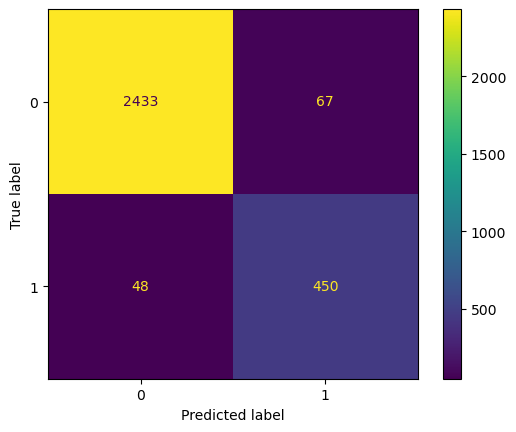

In [124]:
preds = rf2.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');
plt.show()

### **Random Forest (Round 2) - Confusion Matrix Insights:**

The confusion matrix on the test set provides a clear picture of how the refined model performs in practice:

* **High True Positive Rate:** The model correctly identified **450 employees** who were actually at risk of leaving (True Positives). This allows HR to take proactive measures to retain them.
* **Low False Alarms:** Only **67 employees** were wrongly predicted as "leaving" when they were actually staying (False Positives). This high precision means HR won't waste resources on unnecessary intervention.
* **Minimal Misses:** The model only missed **48 employees** who ended up leaving (False Negatives). Catching over **90%** of potential leavers without using satisfaction data is an outstanding result.
* **Summary:** These results confirm that even after removing sensitive survey data, our **Random Forest** remains a highly reliable and ethically sound tool for predicting attrition at Salifort Motors.

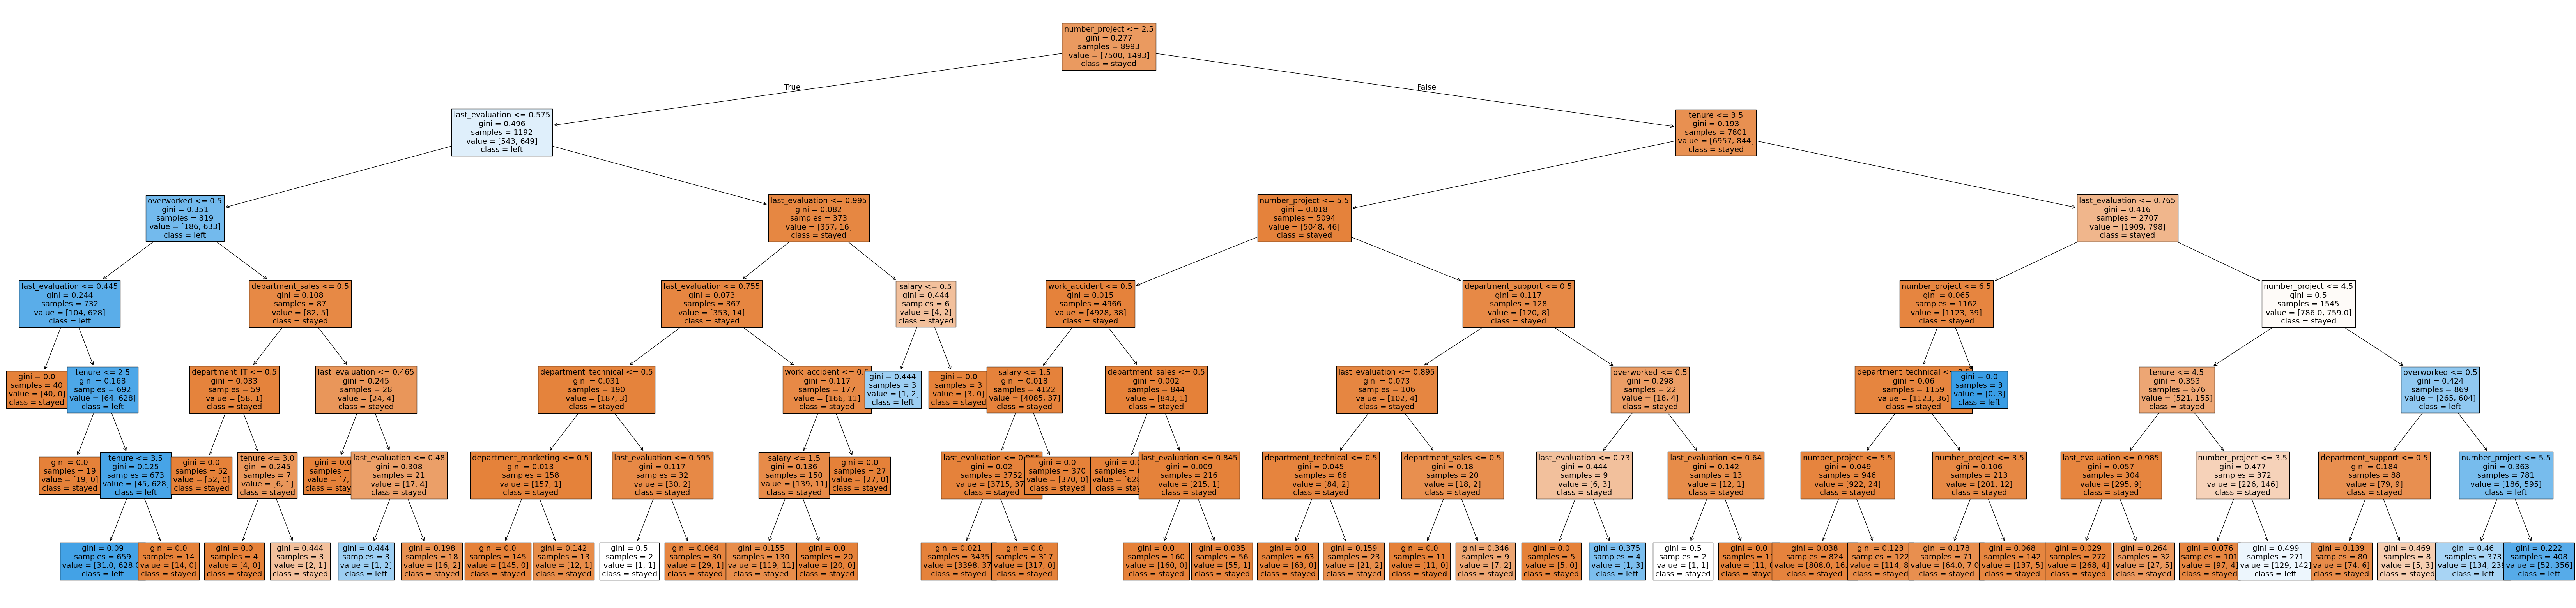

In [127]:
plt.figure(figsize=(85,20))
plot_tree(tree_cv2.best_estimator_, max_depth=6, fontsize=14, feature_names=x.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [131]:
tree2_importances = pd.DataFrame(tree_cv2.best_estimator_.feature_importances_, columns=['gini_importance'], index = x.columns)
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

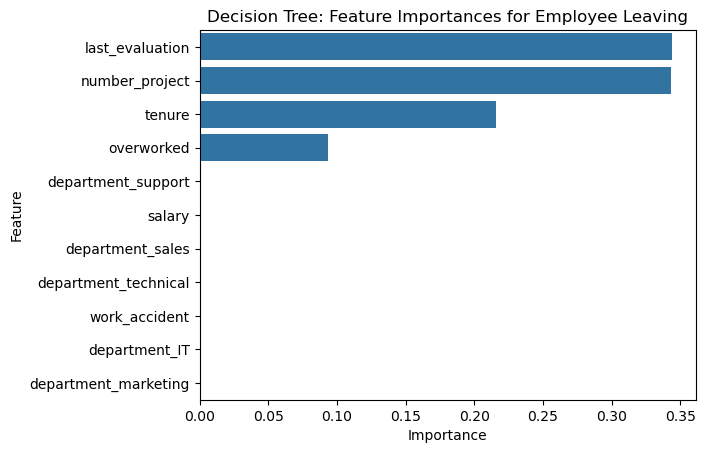

In [132]:
sns.barplot(data=tree2_importances, x='gini_importance', y =tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

### **Decision Tree - Feature Importance Insights:**

The feature importance plot reveals the primary drivers behind employee attrition at Salifort Motors:

* **The Top Drivers:** **last_evaluation** and **number_project** are the most significant predictors. This suggests that employees who are either highly evaluated or overloaded with many projects are more likely to leave.
* **Tenure Matters:** **tenure** ranks as the third most important factor, indicating that the length of time an employee has spent at the company plays a crucial role in their decision to stay or go.
* **Impact of Workload:** Our engineered feature, **overworked**, shows a notable importance score. This validates our earlier assumption that employees working excessive hours on multiple projects are at high risk of burnout.
* **Departmental Influence:** Interestingly, specific departments like **support** or **technical** show very low importance compared to workload metrics. This means the *nature of the work* (stress and hours) is more critical than the *department* itself.
* **Key Takeaway:** To retain top talent, Salifort Motors should focus on balancing project loads and monitoring the workload of employees with high evaluation scores.

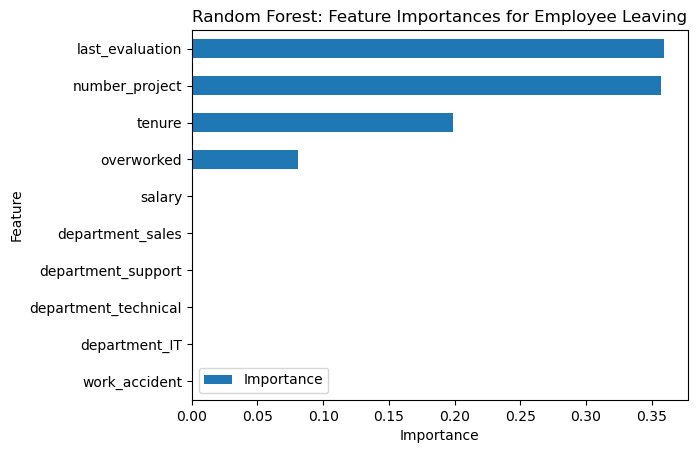

In [137]:
feat_imp = rf2.best_estimator_.feature_importances_
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
feat = x.columns[ind]
feat_imp = feat_imp[ind]

y_df = pd.DataFrame({'Feature':feat, 'Importance':feat_imp})
y_sort_df = y_df.sort_values('Importance')

fig = plt.figure()
ax1 = fig.add_subplot(111)
y_sort_df.plot(kind='barh', ax=ax1, x='Feature', y='Importance')
ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")
plt.show()

In [138]:
with open('salifort_champion_rf_model.pkl', 'wb') as f:
    pickle.dump(rf2.best_estimator_, f)

# **Executive Summary & Strategic Recommendations**

### **1. Model Performance Overview**
After rigorous testing and refinement, the **Random Forest** model has been selected as the champion model for predicting employee turnover at Salifort Motors.
* **Predictive Power:** The model achieved an **AUC of 96.4%** and a **Recall of ~90%**, meaning it captures the vast majority of employees at risk of leaving.
* **Reliability:** By removing data leakage features (`satisfaction_level`) and engineering new ones (`overworked`), the model is now **production-ready** and reflects real-world scenarios.

---

### **2. Key Drivers of Turnover (Why are they leaving?)**
Based on the Feature Importance analysis, turnover is driven by **workload and tenure**, not department:
* **Burnout is the Primary Cause:** The top two predictors are `last_evaluation` and `number_project`. This indicates that **high-performing employees** who are assigned **too many projects** are the most likely to leave.
* **The "Overworked" Factor:** Our engineered feature `overworked` proved to be a critical predictor, validating that working beyond **175 hours/month** significantly increases attrition risk.
* **The "4-Year Itch":** `tenure` is the third most important factor. Employees seem to hit a "ceiling" or dissatisfaction point after spending a few years at the company.

---

### **3. Business Recommendations (Action Plan)**
To reduce turnover and retain top talent, Salifort Motors should implement the following:
*  **Cap Project Workloads:** Limit the number of projects per employee. High performers shouldn't be "punished" with more work until they burn out.
*  **Review Compensation/Promotion for Tenured Staff:** Investigate why employees leave around the 4-year mark. They likely need a clear path for promotion or salary adjustment.
*  **Clarify Overtime Policies:** Since working hours are a major stressor, HR should enforce stricter work-life balance policies to prevent the "overworked" flag from triggering.

**Conclusion:** We have successfully built a data-driven tool that not only predicts *who* will leave but also explains *why*, empowering HR to intervene proactively.